## Importing Libraries

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:54<00:00, 24.2MB/s]
100% 1.21G/1.21G [00:54<00:00, 24.0MB/s]


In [ ]:
!unzip /content/gtzan-dataset-music-genre-classification.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

import librosa
import librosa.display


import torch
from torch import nn
from torchvision import models, transforms, datasets, utils

from time import time
from tqdm import tqdm

## Defining Parameters

In [ ]:
seed = 12
np.random.seed(seed)

path = "/content/gtzan-dataset-music-genre-classification/"

path_audio_files = path + "Data/genres_original/"

#path_imgs = "/content/mel_spectrogram_imgs/"
path_imgs = "/content/Data/images_original/"

batch_size = 50

hop_length = 512

n_fft = 2048

device = 'cuda' if torch.cuda.is_available() else 'cpu'

genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

## Load and Transform the Data

In [ ]:
%%time

# Define Tranforms
train_transforms = transforms.Compose([
    transforms.Resize((44, 44)),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the data
train_dataset = datasets.ImageFolder(path_imgs, transform = train_transforms)

torch.manual_seed(1)
num_train_samples = len(train_dataset)
#num_train_samples = 20000


print(f"Length of Train:{len(train_dataset)}")


# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

# Classes
classes = train_dataloader.dataset.classes
print(classes)

Length of Train:999
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
CPU times: user 7.16 ms, sys: 852 µs, total: 8.02 ms
Wall time: 8.59 ms


#Generative Adversarial Network Part

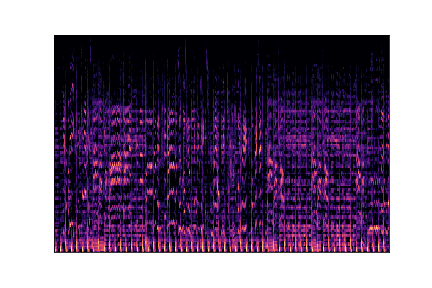

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
spec = cv2.imread("/content/Data/images_original/disco/disco00008.png")
cv2_imshow(spec)

In [ ]:
spec.shape

(288, 432, 3)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Critic(nn.Module):

    def __init__(self, im_chan=3, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [ ]:
n_epochs = 1100
z_dim = 64
display_step = 50
batch_size = 50
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

In [ ]:
#os.mkdir("/content/grids/")

#t = "fake"

def show_tensor_images(image_tensor, num_images=25, size=(3, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    global t

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    
    """plt.imsave('/content/grids/' + t + ".png", image_grid.permute(1, 2, 0).squeeze())

    if t == "fake":
      t = "real"
    else:
      t = "fake" """

    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [ ]:
def get_gradient(crit, real, fake, epsilon):

    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)

    return penalty

In [ ]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)

    return gen_loss

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    return crit_loss

In [ ]:
import matplotlib.pyplot as plt

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    print("Epoch:", epoch)
    # Dataloader returns the batches
    for real, _ in tqdm(train_dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)

            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
            torch.save(gen.state_dict(), "G.pth")
            torch.save(crit.state_dict(), "D.pth")

        cur_step += 1

In [ ]:
torch.save(gen.state_dict(), "G.pth")
torch.save(crit.state_dict(), "D.pth")

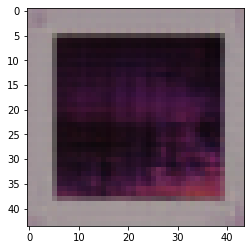

In [ ]:
fake_noise = get_noise(1, 64, device=device)
fake = gen(fake_noise)
fake = fake.detach().cpu()
fake = (fake + 1) / 2
fake = torch.reshape(fake, (-1, 44, 44))
utils.save_image(fake, "fake.png")
plt.imshow(fake.permute(1, 2, 0))

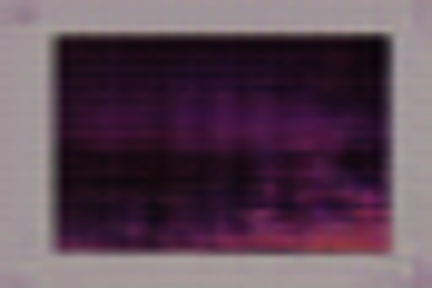

In [ ]:
from PIL import Image
fake = Image.open("/content/fake.png")
fake = fake.resize((432, 288))
fake.save("/content/fake.png")
fake = Image.open("/content/fake.png")
fake


In [ ]:
!pip install torch-fidelity
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 27.6 MB/s 


In [ ]:
from torchmetrics.image.kid import KernelInceptionDistance

metricvalues = []
fvalues = [64, 192, 768, 2048]

for f in fvalues:
  avg = 0
  count = 0
  for real, _ in tqdm(train_dataloader):
    bs = len(real)
    kid = KernelInceptionDistance(feature=f, subset_size=bs)
    fake_noise = get_noise(bs, z_dim, device=device)
    fake = gen(fake_noise)

    real = real.to(torch.uint8)
    fake = fake.detach().cpu()
    fake = fake.to(torch.uint8)

    kid.update(real, real=True)
    kid.update(fake, real=False)

    avg += kid.compute()[0]
    kid.reset()
    count += 1

    if count == 10:
      avg /= 10
      metricvalues.append(avg)
      break

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

 45%|████▌     | 9/20 [03:17<04:01, 21.93s/it]


[tensor(2.0333), tensor(14.2453), tensor(0.0073), tensor(0.4427)]


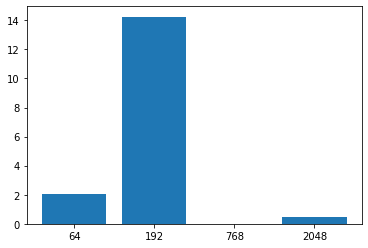

In [ ]:
print(metricvalues)
plt.bar([str(f) for f in fvalues], metricvalues)
plt.show()